In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning
import warnings

calories = pd.read_csv('../Dataset/calories.csv')
exercise = pd.read_csv('../Dataset/exercise.csv')
df = pd.merge(exercise, calories, on = 'User_ID')
df = df.drop(columns=['User_ID'])
#Mapper male til 1 og kvinder til 0 for at spare data
df['Gender'] = df['Gender'].map({'male': 1, 'female': 0})
df = df.reset_index()

#Vi laver feature transformation til vores data nu, og standardizerer det
scaler = StandardScaler()
df[['Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']] = scaler.fit_transform(df[['Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']])

X = df.drop(columns=['Calories','index'])
X
y = df['Calories']

df.head()


,index,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,1,68,1.089582,1.265909,1.619127,0.989404,0.994023,231.0
1,1,0,20,-0.593726,-0.995458,-0.183990,-0.158461,0.352342,66.0
2,2,1,69,0.318066,0.268247,-1.265861,-0.784569,-1.701035,26.0
3,3,0,34,0.318066,-0.263839,-0.304198,0.467647,0.609015,71.0
4,4,0,27,-1.435380,-1.128480,-0.664821,-1.515029,-0.289338,35.0


Best lambda: 0.2848, CV error: 127.1224


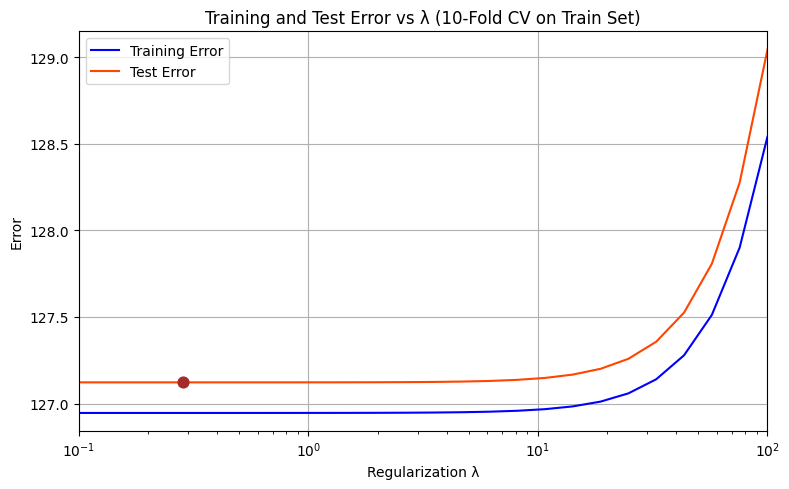

In [ ]:
# Define the lambda range that mirrors the original plot
lambdas = np.logspace(-2,2,100)

# Split the dataset into train and test for error evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For each lambda, perform 10-fold CV on training set to estimate test error,
# and calculate training error on the full training set
cv = KFold(n_splits=10, shuffle=True, random_state=42)

train_errors = []
cv_errors = []

for l in lambdas:
    model = make_pipeline(StandardScaler(), Ridge(alpha=l))
    # Train error on training set
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_errors.append(train_mse)
    
    # Cross-validation error (proxy for test/generalization error)
    cv_mse = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
    cv_errors.append(cv_mse)

min_index = np.argmin(cv_errors)
best_lambda = lambdas[min_index]
best_error = cv_errors[min_index]

print(f"Best lambda: {best_lambda:.4f}, CV error: {best_error:.4f}")

# Plot to match the style of the example
plt.figure(figsize=(8, 5))
plt.plot(lambdas, train_errors, label="Training Error", color='blue')
plt.plot(lambdas, cv_errors, label="Test Error", color='orangered')
plt.scatter([lambdas[min_index]], cv_errors[min_index],
            color='brown', s=60, zorder=5)
plt.xlim(1e-1, 1e2)
plt.xscale('log')
plt.yscale('linear')
plt.xlabel("Regularization λ")
plt.ylabel("Error")
plt.title("Training and Test Error vs λ (10-Fold CV on Train Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ridge_regression_errors.png', dpi=300)
plt.show()


In [4]:
# Re-prepare data from the original DataFrame
feature_names = X.columns.tolist()

# Refit the pipeline with the correct data structure
best_model = make_pipeline(StandardScaler(), Ridge(alpha=best_lambda))
best_model.fit(X_train, y_train)

# Extract steps
scaler_step = best_model.named_steps['standardscaler']
ridge_step = best_model.named_steps['ridge']
coefs = ridge_step.coef_
intercept = ridge_step.intercept_

# Output weight interpretation
weights_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight (w_i)': coefs
})

weights_df


,Feature,Weight (w_i)
0,Gender,-0.686663
1,Age,8.499936
2,Height,-2.411709
3,Weight,4.294021
4,Duration,55.017263
5,Heart_Rate,18.995159
6,Body_Temp,-13.172108


Færdig med Regression part a)

In [5]:
#Baseline model

# Use y from your dataset (already defined earlier)
K1 = 10  # outer folds
outer_cv = KFold(n_splits=K1, shuffle=True, random_state=42)

baseline_mse_scores = []

for train_idx, test_idx in outer_cv.split(X):
    # Split into training and test for this outer fold
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Baseline model: mean of y_train
    y_pred_baseline = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
    
    # Compute and store MSE for this outer fold
    mse = mean_squared_error(y_test, y_pred_baseline)
    baseline_mse_scores.append(mse)

# Final estimated generalization error (average over outer folds)
baseline_avg_mse = np.mean(baseline_mse_scores)
print(f"Baseline Model - Estimated Generalization Error (MSE): {baseline_avg_mse:.4f}")


Baseline Model - Estimated Generalization Error (MSE): 3901.9368


In [ ]:
#Takes roughly 29 minutes

# Outer and inner CV
K1 = K2 = 10
outer_cv = KFold(n_splits=K1, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=K2, shuffle=True, random_state=42)

# Hyperparameter grids
lambda_values = np.logspace(-2, 2, 10)
hidden_units = [1, 2, 4, 8, 16]

# Storage for results
results = []

for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), start=1):
    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

    ## === Ridge Regression (Inner Loop) ===
    best_lambda = None
    best_ridge_score = np.inf

    for l in lambda_values:
        ridge_scores = []

        for inner_train_idx, inner_val_idx in inner_cv.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer.iloc[inner_train_idx], X_train_outer.iloc[inner_val_idx]
            y_train_inner, y_val_inner = y_train_outer.iloc[inner_train_idx], y_train_outer.iloc[inner_val_idx]

            model = make_pipeline(StandardScaler(), Ridge(alpha=l))
            model.fit(X_train_inner, y_train_inner)
            y_val_pred = model.predict(X_val_inner)
            ridge_scores.append(mean_squared_error(y_val_inner, y_val_pred))

        avg_score = np.mean(ridge_scores)
        if avg_score < best_ridge_score:
            best_ridge_score = avg_score
            best_lambda = l

    final_ridge_model = make_pipeline(StandardScaler(), Ridge(alpha=best_lambda))
    final_ridge_model.fit(X_train_outer, y_train_outer)
    y_pred_ridge = final_ridge_model.predict(X_test_outer)
    ridge_test_error = mean_squared_error(y_test_outer, y_pred_ridge)

    ## === ANN (Inner Loop) ===
    best_h = None
    best_ann_score = np.inf

    for h in hidden_units:
        ann_scores = []

        for inner_train_idx, inner_val_idx in inner_cv.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer.iloc[inner_train_idx], X_train_outer.iloc[inner_val_idx]
            y_train_inner, y_val_inner = y_train_outer.iloc[inner_train_idx], y_train_outer.iloc[inner_val_idx]

            ann_model = make_pipeline(
                StandardScaler(),
                MLPRegressor(hidden_layer_sizes=(h,), max_iter=1000, early_stopping=True,
                             n_iter_no_change=10, random_state=42)
            )

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning)
                ann_model.fit(X_train_inner, y_train_inner)

            y_val_pred = ann_model.predict(X_val_inner)
            ann_scores.append(mean_squared_error(y_val_inner, y_val_pred))

        avg_score = np.mean(ann_scores)
        if avg_score < best_ann_score:
            best_ann_score = avg_score
            best_h = h

    final_ann_model = make_pipeline(
        StandardScaler(),
        MLPRegressor(hidden_layer_sizes=(best_h,), max_iter=1000, early_stopping=True,
                     n_iter_no_change=10, random_state=42)
    )

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        final_ann_model.fit(X_train_outer, y_train_outer)

    y_pred_ann = final_ann_model.predict(X_test_outer)
    ann_test_error = mean_squared_error(y_test_outer, y_pred_ann)

    ## === Baseline ===
    y_pred_baseline = np.full_like(y_test_outer, fill_value=y_train_outer.mean(), dtype=float)
    baseline_error = mean_squared_error(y_test_outer, y_pred_baseline)

    # Store results for this fold
    results.append({
        'i': outer_fold,
        'h*_i': best_h,
        'E^test_ann': round(ann_test_error, 2),
        'lambda*_i': best_lambda,
        'E^test_ridge': round(ridge_test_error, 2),
        'E^test_baseline': round(baseline_error, 2)
    })

# Convert to DataFrame
cv_results_df = pd.DataFrame(results)


ModuleNotFoundError: No module named 'ace_tools'

In [8]:
cv_results_df

,i,h*_i,E^test_ann,lambda*_i,E^test_ridge,E^test_baseline
0,1,16,8.48,0.215443,129.60,3931.97
1,2,16,9.22,0.077426,134.41,4147.41
2,3,16,8.34,0.215443,134.97,3768.80
3,4,16,8.14,0.077426,129.13,3874.99
4,5,16,6.66,0.599484,114.52,3565.57
5,6,16,8.37,0.215443,133.26,4055.30
6,7,16,9.69,0.215443,126.25,3984.55
7,8,16,7.96,0.215443,123.37,3858.98
8,9,16,8.96,0.599484,122.21,3828.66
9,10,16,7.72,0.215443,133.91,4003.14


In [11]:

from scipy.stats import ttest_rel
from scipy.stats import t

# Provided test errors from the table (10 outer folds)
ann_errors = np.array([8.48, 9.22, 8.34, 8.14, 6.66, 8.37, 9.69, 7.96, 8.96, 7.72])
ridge_errors = np.array([129.60, 134.41, 134.97, 129.13, 114.52, 133.26, 126.25, 123.37, 122.21, 133.91])
baseline_errors = np.array([3931.97, 4147.41, 3768.80, 3874.99, 3565.57, 4055.30, 3984.55, 3858.98, 3828.66, 4003.14])

# Function to compute paired t-test results
def paired_t_test(a, b, alpha=0.05):
    diff = a - b
    d_bar = np.mean(diff)
    se = np.std(diff, ddof=1) / np.sqrt(len(diff))
    t_stat = d_bar / se
    df = len(diff) - 1
    ci = t.interval(1 - alpha, df, loc=d_bar, scale=se)
    p_value = ttest_rel(a, b).pvalue
    return d_bar, ci, p_value, t_stat

# Perform all pairwise comparisons
ann_vs_ridge = paired_t_test(ridge_errors, ann_errors)
ann_vs_baseline = paired_t_test(baseline_errors, ann_errors)
ridge_vs_baseline = paired_t_test(baseline_errors, ridge_errors)

# Prepare data for LaTeX table
results_df = pd.DataFrame({
    'Comparison': ['ANN vs. Ridge', 'ANN vs. Baseline', 'Ridge vs. Baseline'],
    'd̄': [f"{x[0]:.4f}" for x in [ann_vs_ridge, ann_vs_baseline, ridge_vs_baseline]],
    '95% CI': [f"[{x[1][0]:.4f}, {x[1][1]:.4f}]" for x in [ann_vs_ridge, ann_vs_baseline, ridge_vs_baseline]],
    'p-value': [f"{x[2]:.2e}" for x in [ann_vs_ridge, ann_vs_baseline, ridge_vs_baseline]],
    't-stat': [f"{x[3]:.4f}" for x in [ann_vs_ridge, ann_vs_baseline, ridge_vs_baseline]]
})
results_df



,Comparison,d̄,95% CI,p-value,t-stat
0,ANN vs. Ridge,119.8090,"[115.2794, 124.3386]",5.13e-13,59.8352
1,ANN vs. Baseline,3893.5830,"[3777.0260, 4010.1400]",6.30e-14,75.5673
2,Ridge vs. Baseline,3773.7740,"[3660.2173, 3887.3307]",6.60e-14,75.1771
